In [2]:
# load .env file
from dotenv import load_dotenv
load_dotenv()

# check if ANTHROPIC_API_KEY is set
import os


In [3]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_anthropic

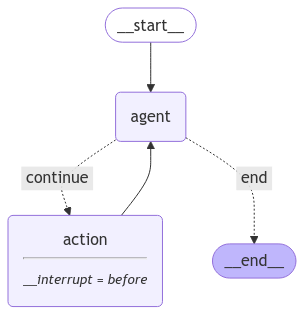

In [33]:
# Set up the tool
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool
from langgraph.graph import MessagesState, START
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return [
        "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    ]

tools = [search]
tool_node = ToolNode(tools)

# Set up the model

model = ChatAnthropic(model="claude-3-5-sonnet-20240620")
model = model.bind_tools(tools)


# Define nodes and conditional edges


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Set up memory
memory = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable

# We add in `interrupt_before=["action"]`
# This will add a breakpoint before the `action` node is called
app = workflow.compile(checkpointer=memory, interrupt_before=["action"])

display(Image(app.get_graph().draw_mermaid_png()))

In [34]:
from langchain_core.messages import HumanMessage

thread = {"configurable": {"thread_id": "3"}}
# inputs = [HumanMessage(content="search for the weather in sf now")]
inputs = [HumanMessage(content="give me the temperature in sf now")]
for event in app.stream({"messages": inputs}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

give me the temperature in sf now
================================== Ai Message ==================================

[{'text': "Certainly! To get the current temperature in San Francisco, I'll need to search for that information online. Let me do that for you.", 'type': 'text'}, {'id': 'toolu_01LLgeJhvj5NC7PwoFMqVsQs', 'input': {'query': 'current temperature in San Francisco'}, 'name': 'search', 'type': 'tool_use'}]
Tool Calls:
  search (toolu_01LLgeJhvj5NC7PwoFMqVsQs)
 Call ID: toolu_01LLgeJhvj5NC7PwoFMqVsQs
  Args:
    query: current temperature in San Francisco


In [35]:
for event in app.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "Certainly! To get the current temperature in San Francisco, I'll need to search for that information online. Let me do that for you.", 'type': 'text'}, {'id': 'toolu_01LLgeJhvj5NC7PwoFMqVsQs', 'input': {'query': 'current temperature in San Francisco'}, 'name': 'search', 'type': 'tool_use'}]
Tool Calls:
  search (toolu_01LLgeJhvj5NC7PwoFMqVsQs)
 Call ID: toolu_01LLgeJhvj5NC7PwoFMqVsQs
  Args:
    query: current temperature in San Francisco
================================= Tool Message =================================
Name: search

["It's sunny in San Francisco, but you better look out if you're a Gemini 😈."]
================================== Ai Message ==================================

[{'text': "I apologize, but it seems the search result didn't provide the specific temperature information we're looking for. Let me try a more specific search query to get the current temperature in San Fran

In [40]:
from langgraph.interactive import InteractionContext

# Update graph compilation
app = workflow.compile(interrupt_before=["action"])

# Start the interaction
thread = {"configurable": {"thread_id": "17"}}
inputs = [HumanMessage(content="give me the temperature in vienna, austria now")]

# Create an interaction context
with InteractionContext(app) as context:
    # Start the flow
    for event in context.stream({"messages": inputs}, thread, stream_mode="values"):
        event["messages"][-1].pretty_print()
        
        if context.has_interrupted():
            # Get the current state
            current_state = context.get_state()
            
            # Modify the messages to change the location
            new_messages = current_state["messages"]
            new_messages.append(HumanMessage(content="actually, check vienna, virginia instead"))
            
            # Continue with modified state
            modified_state = {"messages": new_messages}
            for new_event in context.continue_with(modified_state):
                new_event["messages"][-1].pretty_print()

ModuleNotFoundError: No module named 'langgraph.interactive'

In [45]:
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.graph import MessagesState, START, END
from langgraph.graph import StateGraph
from langgraph.prebuilt import ToolNode

# Mock temperature tool
@tool
def get_temperature_for_city(city: str, country: str) -> str:
    """Get the current temperature for a city."""
    temps = {
        ("Vienna", "Austria"): "12°C",
        ("Vienna", "United States"): "68°F"
    }
    return temps.get((city, country), "Temperature data not available")

# Set up the model and tools
model = ChatAnthropic(model="claude-3-5-sonnet-20240620")
tools = [get_temperature_for_city]
model = model.bind_tools(tools)
tool_node = ToolNode(tools)

def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "continue"
    return "end"

def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}

# Create and configure the graph
# Create and configure the graph
workflow = StateGraph(MessagesState)
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END
    }
)
workflow.add_edge("action", "agent")

# Compile the graph with interruption before action
app = workflow.compile(interrupt_before=["action"])

# Run first query
thread = {"configurable": {"thread_id": "1"}}
inputs = [HumanMessage(content="What's the temperature in Vienna, Austria?")]

# First request with interruption
for event in app.stream({"messages": inputs}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()
    
# Continue after reviewing the tool call
for event in app.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

# Second query
print("\nSecond query:")
inputs = [HumanMessage(content="What's the temperature in Vienna, Virginia, United States?")]
for event in app.stream({"messages": inputs}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

# Continue after reviewing the tool call
for event in app.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What's the temperature in Vienna, Austria?
================================== Ai Message ==================================

[{'text': 'To get the temperature in Vienna, Austria, I can use the get_temperature_for_city function. Let me fetch that information for you.', 'type': 'text'}, {'id': 'toolu_019F65DSGLbLBrVoi8TJxVFy', 'input': {'city': 'Vienna', 'country': 'Austria'}, 'name': 'get_temperature_for_city', 'type': 'tool_use'}]
Tool Calls:
  get_temperature_for_city (toolu_019F65DSGLbLBrVoi8TJxVFy)
 Call ID: toolu_019F65DSGLbLBrVoi8TJxVFy
  Args:
    city: Vienna
    country: Austria


EmptyInputError: Received no input for __start__